In [22]:
using PyPlot

In [23]:
x_data = collect(linspace(0., 10.))
y_data = zeros(length(x_data))
sigma = 10.0
y_error = ones(length(x_data))*sigma
for idx=1:length(x_data)
    dev = 2.*sigma*rand() - 1.0
    y_data[idx] = x_data[idx]^2 + dev
end

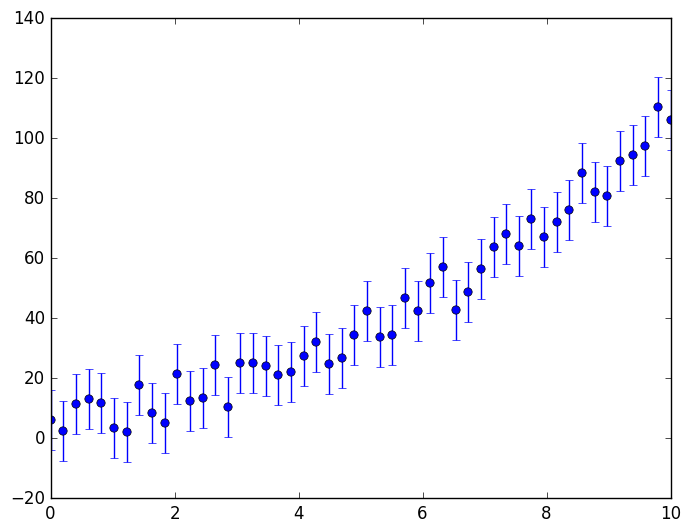

(PyObject <matplotlib.lines.Line2D object at 0x7fcf064a4490>,(PyObject <matplotlib.lines.Line2D object at 0x7fcf064b9710>,PyObject <matplotlib.lines.Line2D object at 0x7fcf06502510>),(PyObject <matplotlib.collections.LineCollection object at 0x7fcf0648e2d0>,))

In [24]:
errorbar(x_data, y_data, y_error, fmt="o", label="Data")

In [25]:
function parabola_model(x, p)
    a = p[1]
    b = p[2]
    c = p[3]
    return a*x.^2 + b*x + c
end

parabola_model (generic function with 1 method)

In [26]:
lsq_fit_params = [1.2, 0.3, -0.2]
param_errors = [1.0, 1.0, 1.0]
y_model = zeros(length(x_data))
for idx=1:length(x_data)
    y_model[idx] = parabola_model(x_data[idx], lsq_fit_params)
end

chi_best = sum(((y_data-y_model)/y_error)^2)

0.26534378213803295

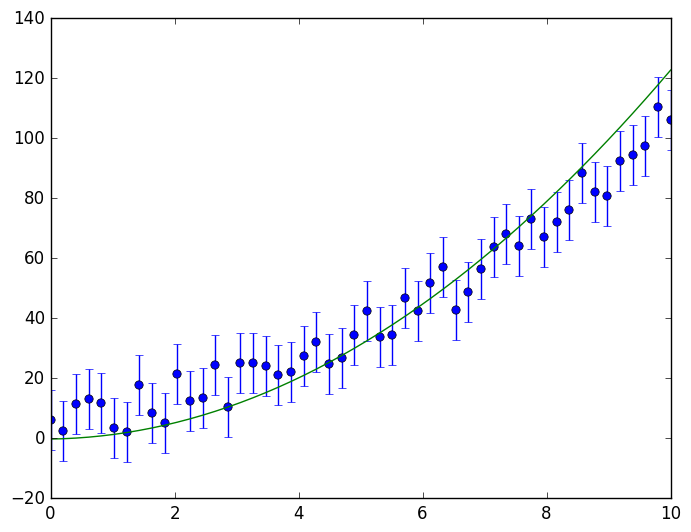

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fcf06454ad0>

In [27]:
errorbar(x_data, y_data, y_error, fmt="o", label="Data")
plot(x_data,y_model)

In [32]:
"""
# Finds the best fit paramaters for a model using an 
# affine-invariant markov chain:
# Foreman-Mackey et al. (2014) - 'emc' 'mcmc hammer'
#
# Input:
#           model: A function to model the data
#               x: The x values of the data
#               y: The y values of the data
#         y_error: Y value error bars
#  lsq_fit_params: Best fit parameters from doing a
#                  least squares fit
#    param_errors: Errors on the least squares fit  parameters
#        chi_best: Chi squared value from least squares fit
#
# Output:
#   param_mean: Mean value of the parameters found using MCMC
#    param_std: Standard deviation of the mean values
"""
function mcmc_fit!(model, x::Vector, y::Vector, y_error::Vector, lsq_fit_params::Vector, 
                   param_errors::Vector, chi_best::Float64, param_mean::Vector, param_std::Vector)  
    nparam = length(lsq_fit_params)
    nwalkers = nparam * 3
    nsteps = 10000
    # Set up arrays to hold the results:
    par_mcmc = zeros(nwalkers,nsteps,nparam)
    chi_mcmc = zeros(nwalkers,nsteps)
    # Initialize walkers:
    par_trial = lsq_fit_params
    for j=1:nwalkers
        # Select from within uncertainties:
        chi_trial = 1e100
        # Only initiate models with reasonable chi-square values:
        while chi_trial > (chi_best + 1000)
            par_trial = lsq_fit_params + param_errors.*randn(nparam)
            y_model = model(x, par_trial)
            chi_trial = sum(((y_data-y_model)./y_error).^2)
        end
        chi_mcmc[j,1]=chi_trial
        par_mcmc[j,1,:]=par_trial
        println("Success: ",par_trial,chi_trial)
    end
    
    # Initialize scale length & acceptance counter:
    ascale = 2.0
    accept = 0
    # Next, loop over steps in markov chain:
    for i=2:nsteps
        for j=1:nwalkers
            ipartner = j
            # Choose another walker to 'breed' a trial step with:
            while ipartner == j
                ipartner = ceil(Int,rand()*nwalkers)
            end
            # Now, choose a new set of parameters for the trial step:
            z=(rand()*(sqrt(ascale)-1.0/sqrt(ascale))+1.0/sqrt(ascale))^2
            par_trial=vec(z*par_mcmc[j,i-1,:]+(1.0-z)*par_mcmc[ipartner,i-1,:])
            # Compute model & chi-square:    
            y_model_trial = model(x,par_trial)
            chi_trial = sum(((y_data-y_model_trial)./y_error).^2)
            # Next, determine whether to accept this trial step:
            alp = z^(nparam-1)*exp(-0.5*(chi_trial - chi_mcmc[j,i-1]))
            if alp >= rand()
                # If step is accepted, add it to the chains!
                par_mcmc[j,i,:] = par_trial
                chi_mcmc[j,i,:] = chi_trial
                accept = accept + 1
            else
                # If step is rejected, then copy last step:
                par_mcmc[j,i,:] = par_mcmc[j,i-1,:]
                chi_mcmc[j,i,:] = chi_mcmc[j,i-1]
            end
        end
        if mod(i,1000) == 0
            frac_acc = accept/(1000*nwalkers)
            println("Number of steps: ",i," acceptance rate: ",frac_acc)
            ascale = 1.0 + (frac_acc/0.25)*(ascale-1.0)
            accept = 0
        end
    end
    
    # Now, determine time of burn-in by calculating first time median is crossed:
    iburn = 0
    for i=1:nparam
      med_param=median(par_mcmc[1:nwalkers,1:nsteps,i])
      for j=1:nwalkers
        istep=2
        while (par_mcmc[j,istep,i] > med_param) == (par_mcmc[j,istep-1,i] > med_param) && (istep < nsteps)
          istep=istep+1
        end
        if istep >= iburn
          iburn = istep
        end
      end
    end

    println("Burn-in ends: ",iburn)
    
    for i=1:nparam
        param_mean[i] = mean(vec(par_mcmc[1:nwalkers,iburn:nsteps,i]))
        param_std[i] = std(vec(par_mcmc[1:nwalkers,iburn:nsteps,i]))
    end
end

mcmc_fit! (generic function with 2 methods)

In [33]:
param = zeros(length(lsq_fit_params))
stdev = zeros(length(lsq_fit_params))

fit = mcmc_fit!(parabola_model, x_data, y_data, y_error, lsq_fit_params, param_errors, chi_best, param, stdev)
@printf "a: %8.4f +/- %8.4f\n" param[1] stdev[1]
@printf "b: %8.4f +/- %8.4f\n" param[2] stdev[2]
@printf "c: %8.4f +/- %8.4f\n" param[3] stdev[3]

Success: [0.7714622556137989,-0.5107115051234599,-0.36842416796983357]231.9162489368457
Success: [1.9650340007963445,0.018062357821666986,-0.2337514963184229]738.5115269520184
Success: [1.9437908143979195,-0.6893227803496054,-1.7257519840367175]543.9640147269236
Success: [0.6569165445894608,-2.221537133123419,-0.21000749110500724]648.0513595526959
Success: [0.708882888489269,-0.8847381377325343,-0.1057210052440231]339.14743062341194
Success: [1.0107235611629641,0.3014574643614609,-1.8875755665606277]52.12709147403769
Success: [1.901183227108639,0.025821084923914606,-0.8500597460815085]622.1895653249717
Success: [1.266401858787885,-0.9235871663866269,-0.9302904793457454]45.257180091280304
Success: [1.8072224618261399,-2.057506802854577,-0.7161161700808136]226.92108594252676
Number of steps: 1000 acceptance rate: 0.6431111111111111
Number of steps: 2000 acceptance rate: 0.4341111111111111
Number of steps: 3000 acceptance rate: 0.32322222222222224
Number of steps: 4000 acceptance rate: 0.

In [30]:
y_model_mcmc = zeros(length(x_data))
for idx=1:length(x_data)
    y_model_mcmc[idx] = parabola_model(x_data[idx], [param[1], param[2], param[3]])
end

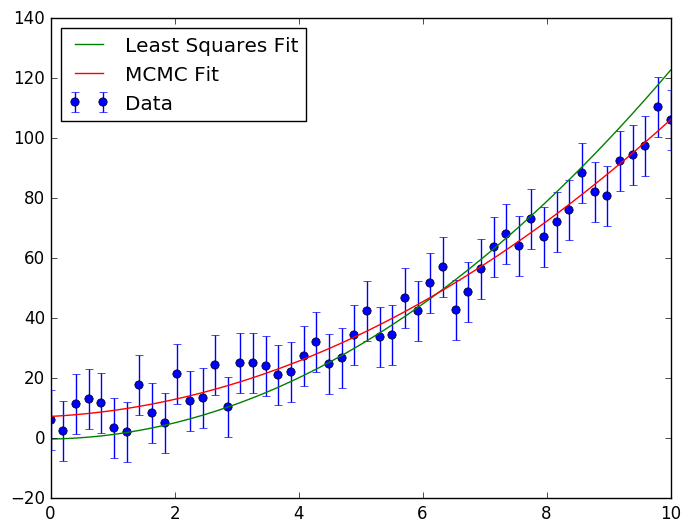

PyObject <matplotlib.legend.Legend object at 0x7fcf0633bd10>

 7.3389 +/-   4.1172


In [31]:
errorbar(x_data, y_data, y_error, fmt="o", label="Data")
plot(x_data, y_model, label="Least Squares Fit")
plot(x_data, y_model_mcmc, label="MCMC Fit")
legend(loc=2)